In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Imaginary time evolution 

Imaginary time is an unphysical, yet powerful, mathematical tool in exploring finite temperature and ground state properties of quantum systems. 
Suppose we are given a Hamiltonian ${\hat H}$, evolving in real time $t$, its associated time evolution propagator is given by the solution of the Schrödinger equation as $e^{-i {\hat H}t}$. The corresponding propagator in imaginary time is obtained by making the switch (with the so-called Wick rotation) $\tau = it$ which yields $e^{-{\hat H}\tau}$. Whether ${\hat H}$ was Hermitian or not, the resulting propagator $e^{-{\hat H}\tau}$ is now non-unitary.

Let us now focus on many-body systems that are described by Hamiltonians of the form ${\hat H} = \sum_i \lambda_i \hat h_i$. Here $\hat h_i$ are some Pauli strings and $\lambda_i$ are the corresponding coefficients.
The initial state is $\lvert \psi (0) \rangle$ and its normalized imaginary time evolution is given by:
$$
\lvert \psi(\tau) \rangle = \frac{1}{N(\tau)} e^{-\hat H \tau} \lvert\psi(0) \rangle
$$
where $N(\tau) =  \sqrt{\langle \psi(0)\rvert e^{-2 \hat H \tau} \lvert\psi(0) \rangle}$ is a factor that enforces normalization. 
If the initial state has a non-zero overlap with the ground state, then the state will become the ground state of the Hamiltonian $\hat H$ as $\tau \to \infty$, as we shall see in the examples below.

The Wick rotated Schrödinger equation is
$$
\frac{\partial}{\partial \tau} \lvert \psi(\tau) \rangle  = -(\hat H - E_\tau \mathbb{I}) \lvert \psi(\tau) \rangle 
$$
Here the term $E_\tau = \langle \psi(\tau)\rvert \hat H \lvert\psi(\tau) \rangle$ is present to make sure that the state remains normalized through the evolution.


Let's look at a simple example. We first express the quantum state of a two-level system (e.g. a qubit) in terms of its eigen-states, 
$$
| \psi \rangle = \frac{ a_0 | E_0 \rangle  + a_1 | E_1 \rangle  }{N}
$$
where $|E_0\rangle $ and $|E_1 \rangle$ ($E_0<E_1$) are the ground and excited states, respectively. $N = \sqrt{|a_0|^2 + |a_1|^2 } $ is the normalization constant. The application of imaginary time operator leads to:
$$
e^{-\tau H} | \psi \rangle \propto a_0 e^{- E_0 \tau }| E_0 \rangle  + a_1 e^{- E_1 \tau } | E_1 \rangle. 
$$
We leave it to the readers to show that the wavefunction evolves to the ground state when $\tau \rightarrow \infty$.


## Variational Quantum Imaginary Time Evolution (Var-QITE)

We can simulate imaginary time evolution using classical computers by evaluating the propagator and applying it to the system wavefunction. There are various classical methods, such as quantum Monte Carlo and density matrix renormalization group for simulating the imaginary time evolution. However, because the dimension of the wavefunction grows exponentially with the system size, classical simulation of many-body quantum systems is generally hard. 

The Variational Quantum Imaginary Time Evolution (Var-QITE) algorithm was first proposed in Ref. [1]. In Var-QITE one does not encode $\lvert \psi(\tau) \rangle$ directly on a quantum computer, instead one encodes the parametrized state. In other words, instead of encoding $\lvert \psi(\tau) \rangle$, we approximate the wavefunction using the parametrized trial state $\lvert \phi(\vec \theta(\tau)) \rangle$ with $\vec \theta(\tau) = (\theta_1(\tau), \theta_2(\tau), \cdots, \theta_N(\tau))$. Again, in analogy to the imaginary case, one expects that the physically relevant states are contained within a small subspace of the full Hilbert space in which $\lvert \psi(\tau) \rangle$ resides. 

The trial state is prepared by using a parametrized quantum circuit (PQC), that is, by applying a sequence of parametrized unitary gates $U(\vec \theta) = U_N(\theta_N) \cdots U_k(\theta_k) \cdots U_1(\theta_1)$ to the initial state $\lvert \psi_0 \rangle$. This state can be expressed as $\lvert \phi(\vec \theta) \rangle = U(\vec \theta) \lvert \vec \psi_0 \rangle$. The term $U_k(\theta_k)$ is the $k$th unitary gate which is controlled by a parameter (angle) $\theta_k$. This gate could be a single qubit gate (i.e. a rotation) or a two-qubit gate (i.e. a controlled rotation). 

According to the McLachlan's variational principle, we set $\delta \; || (\partial/\partial \tau + \hat H E_\tau \mathbb{I}) \lvert \psi(\tau) \rangle || = 0$, where  $|| \,\, |\psi\rangle\,\, || = \sqrt{\langle \psi |\psi\rangle}$. The trick is to replace the full Hilbert state $\lvert \psi(\tau) \rangle$ by $\lvert \phi(\vec \theta(\tau)) \rangle$ to project the desired imaginary evolution onto the manifold of the ansatz space. After applying the McLachlan's variational principle, the resulting update rule for the parameters $\theta$'s is given by
$$
\sum_j A_{ij} \dot{\theta}_j = C_i \quad \text{for each }i, \label{imaginaryevolution}
$$
and where
$$
A_{ij} := \operatorname{Re}\bigg(\frac{\partial \langle \phi(\vec \theta)\rvert}{\partial \theta_i}\frac{\partial \lvert \phi(\vec \theta ) \rangle}{\partial \theta_j}\bigg) \quad \text{and} \quad %C_i := \operatorname{Re}\bigg(-\sum_\alpha \lambda_\alpha \frac{\partial \langle \phi(\vec \theta(\tau))\rvert}{\partial \theta_i} h_\alpha \lvert \phi(\vec \theta (\tau)) \rangle \bigg).
C_i := \operatorname{Re}\bigg(- \frac{\partial \langle \phi(\vec \theta)\rvert}{\partial \theta_i} H \lvert \phi(\vec \theta ) \rangle \bigg) = - \frac{1}{2} \frac {\partial \langle \phi(\vec \theta)\rvert  H \lvert \phi(\vec \theta ) \rangle} {\partial \theta_i}.
$$

The gradient $\dot{\theta} = A^{-1}C$ is also called the natural gradient (strictly speaking, there are some differences. More discussion about relationship between natural gradient and Var-QITE can be found in Ref. [2] and [3].) In this case, both $A_{ij}$ and $C_i$ are real, which means that $\dot \theta$ will also be real, which is a requirement for a parametrized quantum circuit.

In [2]:
from qiskit.primitives import Estimator

from qiskit_algorithms.gradients import LinCombQGT, QFI, ParamShiftEstimatorGradient

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.visualization import *

from scipy import linalg
import numpy as np

from qiskit.quantum_info import SparsePauliOp


In [3]:
estimator = Estimator()

# Build the Hamiltonian ansatz 
def apply_ansatz(circuit, layers, theta, hamiltonian):
    no_terms = len(hamiltonian)
    no_qubits = hamiltonian.num_qubits
    
    for l in range(0, layers):
        for i in range(0, no_terms):
            operator = hamiltonian[i]/hamiltonian[i].coeffs[0]
            evol = PauliEvolutionGate(operator, theta[i + no_terms*l])
            circuit.append(evol, range(no_qubits))
            
# Construct matrix A in the update rule. Here we use the function QFI (Quantum Fisher Information),
# which provides a slightly different definition of A_{ij}
def A_matrix(circuit, theta, parameters):
    qgt = LinCombQGT(estimator)
    qfis = QFI(qgt=qgt).run([circuit], [theta], [parameters]).result().qfis
    return qfis[0]

# Construct vector C in the update rule. 
def C_vector(circuit, hamiltonian, theta, parameters):
    grad = ParamShiftEstimatorGradient(estimator)
    return grad.run(circuit, [hamiltonian], [theta], [parameters]).result().gradients[0]

## Example 1: Ising spin models and Relation with QAOA

Here we first consider an Ising model that we have seen in the Hamiltonian variational ansatz notebook. The Hamiltonian of a 2-spin Ising model is given by:

$H = -[ g \sigma^z_1 \sigma^z_2 + (\sigma^x_1 + \sigma^x_2)] $

where $g$ is the coupling coefficient.

In [4]:
hamiltonian = SparsePauliOp.from_list([('ZZ', -0.5), ('XI', -1), ('IX', -1)])

delta_tau = 0.05
layers = 1   # number of layers in the ansatz

np.random.seed(2)
theta = np.random.rand(layers*len(hamiltonian))* 1e-6
no_qubits = hamiltonian.num_qubits

qite_results = []

# Start imaginary time evolution
for i in range(0, 500):
    parameters = ParameterVector('p', layers*len(hamiltonian)) 
    circuit = QuantumCircuit(no_qubits)
    for n in range(0, no_qubits):
        circuit.h(n)
    apply_ansatz(circuit, layers, parameters, hamiltonian)

    A = A_matrix(circuit, theta, parameters)
    C = C_vector(circuit, hamiltonian, theta, parameters)

    theta = - np.linalg.pinv(A).dot(C)*delta_tau + theta
    #theta = - np.array(C)*delta_tau + theta
    theta = np.real(theta)

    if i%5 == 0:
        E = estimator.run([circuit], [hamiltonian], [theta]).result().values[0]
        print(E)
        qite_results.append([i, E])
qite_results = np.transpose(qite_results)

-2.0000003563387776
-2.0369467706515234
-2.0532253629102284
-2.0587427863943777
-2.0606055333550164
-2.0612335851550574
-2.0614452470846687
-2.0615165692531776
-2.0615406009400807
-2.061548698171278
-2.061551426434808
-2.0615523456882228
-2.0615526554186725
-2.0615527597782846
-2.0615527949408854
-2.0615528067884608
-2.061552810780345
-2.0615528121253583
-2.061552812578542
-2.0615528127312372
-2.0615528127826854
-2.0615528128000205
-2.0615528128058616
-2.061552812807829
-2.0615528128084923
-2.0615528128087157
-2.0615528128087908
-2.061552812808816
-2.0615528128088254
-2.0615528128088276
-2.061552812808829
-2.06155281280883
-2.061552812808829
-2.0615528128088294
-2.0615528128088294
-2.0615528128088294
-2.0615528128088294
-2.0615528128088294
-2.0615528128088294
-2.06155281280883
-2.0615528128088294
-2.06155281280883
-2.0615528128088294
-2.06155281280883
-2.06155281280883
-2.0615528128088294
-2.0615528128088294
-2.061552812808829
-2.0615528128088294
-2.0615528128088294
-2.061552812808829


/Users/lcd/github/gbs-ibm-q/fixes/asset-lib-code-base/Essentials/Chemistry/test-env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/lcd/github/gbs-ibm-q/fixes/asset-lib-code-base/Essentials/Chemistry/test-env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


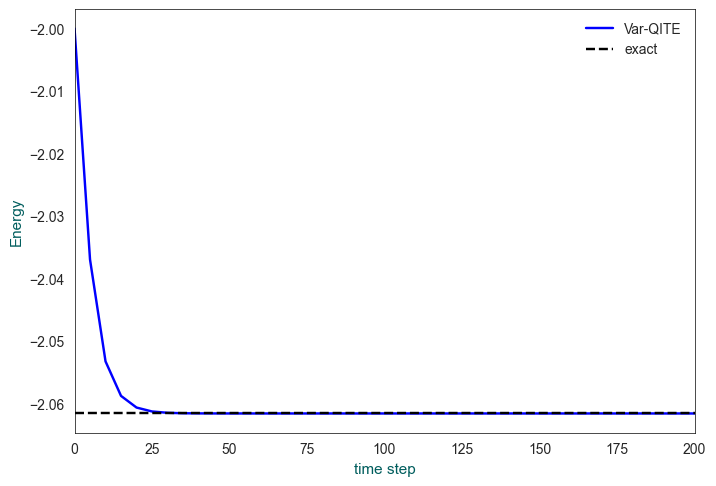

In [5]:
# Let's take a look at the how the average energy changes along the imaginary time evolution 
import matplotlib.pyplot as plt
E_exact = np.sort(linalg.eigvals(hamiltonian.to_matrix()))[0]
plt.plot(qite_results[0], qite_results[1], 'b')
plt.plot([0, 500], [E_exact, E_exact], 'k--')
plt.xlim([0,200])
plt.legend(['Var-QITE', 'exact'])
plt.xlabel('time step')
plt.ylabel('Energy')
plt.show()

In [6]:
# Let's compare the Var-QITE results with gradient descent used in the standard VQE
theta = np.random.rand(layers*len(hamiltonian))* 1e-6
gd_results = []
for i in range(0, 800):
    parameters = ParameterVector('p', layers*len(hamiltonian)) 
    circuit = QuantumCircuit(no_qubits)
    for n in range(0, no_qubits):
        circuit.h(n)
    apply_ansatz(circuit, layers, parameters, hamiltonian)

    C = C_vector(circuit, hamiltonian, theta, parameters)
    theta = - np.array(C)*delta_tau + theta
    theta = np.real(theta)
    
    if i%5 == 0:
        E = estimator.run([circuit], [hamiltonian], [theta]).result().values[0]
        print(E)
        gd_results.append([i, E])
gd_results = np.transpose(gd_results)

-2.0000000000001106
-2.000000000000309
-2.0000000000004805
-2.0000000000007456
-2.000000000001158
-2.0000000000017977
-2.0000000000027907
-2.000000000004333
-2.000000000006726
-2.0000000000104405
-2.0000000000162066
-2.0000000000251568
-2.0000000000390497
-2.000000000060613
-2.0000000000940847
-2.0000000001460405
-2.0000000002266853
-2.0000000003518643
-2.0000000005461676
-2.0000000008477685
-2.0000000013159154
-2.00000000204258
-2.000000003170516
-2.0000000049213105
-2.0000000076389144
-2.0000000118572094
-2.0000000184048927
-2.000000028568279
-2.000000044343995
-2.000000068831227
-2.0000001068405493
-2.0000001658389652
-2.0000002574167715
-2.0000003995643922
-2.0000006202063663
-2.0000009626865127
-2.000001494281279
-2.0000023194123306
-2.000003600150678
-2.000005588032301
-2.0000086734159668
-2.000013462032532
-2.0000208936504267
-2.000032425895905
-2.0000503186817884
-2.000078073538876
-2.0001211103576635
-2.0001878053804996
-2.0002910725977294
-2.0004507474539723
-2.00069711891010

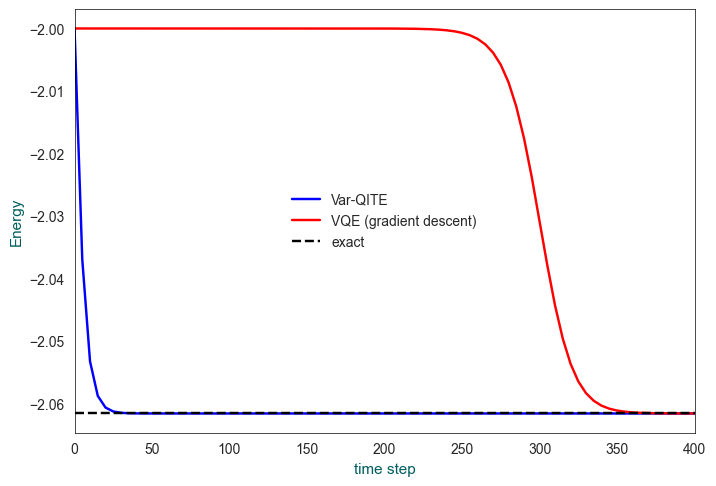

In [7]:
plt.plot(qite_results[0], qite_results[1],'b', gd_results[0], gd_results[1], 'r')
plt.plot([0, 500], [E_exact, E_exact], 'k--')
plt.xlim([0, 400])
plt.legend(['Var-QITE', 'VQE (gradient descent)', 'exact'])
plt.xlabel('time step')
plt.ylabel('Energy')
plt.show()

## Example 2: Hydrogen Molecule 
Similar to previous notebooks, here we demonstrate the capability of Var-QITE in computing the ground state energy for hydrogen molecule at equilibrium bond distance of 0.735 Angstrom. 

In [8]:
hamiltonian = SparsePauliOp.from_list([('ZZ', - 0.01128010425623363),
                                       ('XX', + 0.18093119978423128),
                                       ('IZ', + 0.3979374248431779),
                                       ('ZI', - 0.39793742484317934)])


no_qubits = hamiltonian.num_qubits
layers = 2
delta_tau = 0.05
np.random.seed(2)
theta = np.random.rand(layers*len(hamiltonian))* 1e-5
            
qite_results = []
for i in range(0, 150):
    parameters = ParameterVector('p', layers*len(hamiltonian)) 

    circuit = QuantumCircuit(no_qubits)
    circuit.h(0) # Hadamard gate 
    circuit.x(1) # Pauli-X gate
    circuit.cx(0, 1)

    apply_ansatz(circuit, layers, parameters, hamiltonian)

    A = A_matrix(circuit, theta, parameters)
    C = C_vector(circuit, hamiltonian, theta, parameters)
    theta = - np.linalg.pinv(A).dot(C)*delta_tau + theta
    theta = np.real(theta)
    
    if i%5 == 0:
        E = estimator.run([circuit], [hamiltonian], [theta]).result().values[0]
        print(E)
        qite_results.append([i, E])
qite_results = np.transpose(qite_results)

-0.16777024466728904
-0.3188436539476699
-0.4472943473731489
-0.5495583061765035
-0.6267774857332903
-0.6827721109134587
-0.7222033923596651
-0.7493893906379909
-0.7678595234552202
-0.7802837281361685
-0.7885849964681706
-0.7941066288784822
-0.7977683028199797
-0.800191757128348
-0.8017935518172544
-0.8028513503664318
-0.8035494751714576
-0.8040100602943214
-0.8043138603994019
-0.8045141486507618
-0.8046462174488689
-0.8047333022019861
-0.8047907275568426
-0.8048285781248203
-0.8048535253339619
-0.8048700033843651
-0.8048808407143855
-0.8048879786673122
-0.8048926837986419
-0.8048958107065627


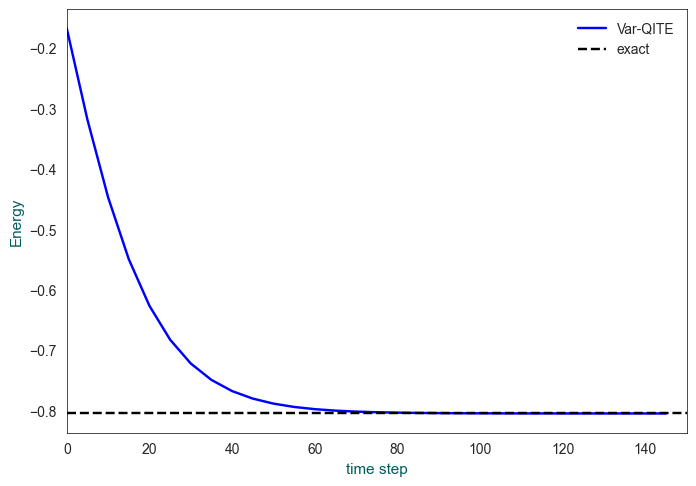

In [9]:
E_exact = np.sort(linalg.eigvals(hamiltonian.to_matrix()))[0]
plt.plot(qite_results[0], qite_results[1], 'b')
plt.plot([0, 500], [E_exact, E_exact], 'k--')
plt.xlim([0,150])
plt.legend(['Var-QITE', 'exact'])
plt.xlabel('time step')
plt.ylabel('Energy')
plt.show()

In [10]:
# Let's compare the Var-QITE results with gradient descent used in the standard VQE
theta = np.random.rand(layers*len(hamiltonian))* 1e-6
gd_results = []

for i in range(0, 1500):
    parameters = ParameterVector('p', layers*len(hamiltonian)) 
    circuit = QuantumCircuit(no_qubits)
    for n in range(0, no_qubits):
        circuit.h(n)
    apply_ansatz(circuit, layers, parameters, hamiltonian)

    C = C_vector(circuit, hamiltonian, theta, parameters)
    theta = - np.array(C)*delta_tau + theta
    theta = np.real(theta)
    
    if i%5 == 0:
        E = estimator.run([circuit], [hamiltonian], [theta]).result().values[0]
        print(E)
        gd_results.append([i, E])
gd_results = np.transpose(gd_results)

0.18093119978321812
0.18093119978145242
0.18093119977697178
0.18093119976379904
0.18093119972166458
0.18093119957903098
0.18093119907823824
0.18093119728070467
0.1809311907458004
0.18093116681686544
0.18093107884594445
0.18093075472499923
0.18092955909843905
0.18092514577861427
0.18090884988282013
0.18084867290376616
0.1806265152234885
0.17980748486028453
0.17680362812692374
0.16599500974880485
0.1296427086199416
0.031061088712653562
-0.12745845753404733
-0.2443210513923258
-0.29142919733308253
-0.3076351874252434
-0.31361214162959045
-0.3159903807620445
-0.31697921014965436
-0.31740870902106516
-0.3176153604053503
-0.31774271837835255
-0.3178575042582035
-0.31799790151726187
-0.3181952483111642
-0.31848550778817875
-0.31891751268320145
-0.3195611981170129
-0.32051736843421047
-0.3219294382589526
-0.32399604825924655
-0.3269805112519082
-0.3312077857609874
-0.33703237120183466
-0.3447557208877393
-0.3544824637245255
-0.3659486965161734
-0.37842657728920587
-0.3908350676464267
-0.402071

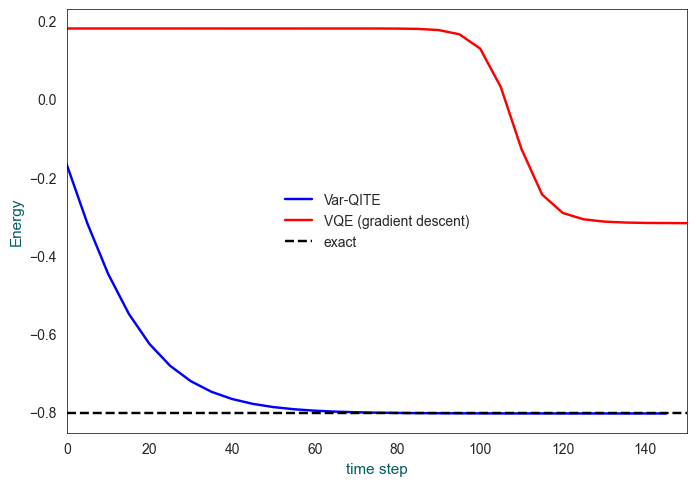

In [11]:
plt.plot(qite_results[0], qite_results[1],'b', gd_results[0], gd_results[1], 'r')
plt.plot([0, 1500], [E_exact, E_exact], 'k--')
plt.xlim([0, 150])
plt.legend(['Var-QITE', 'VQE (gradient descent)', 'exact'])
plt.xlabel('time step')
plt.ylabel('Energy')
plt.show()

## References
1) Sam McArdle, Tyson Jones, Suguru Endo, Ying Li, Simon C. Benjamin & Xiao Yuan . Variational Ansatz-Based Quantum Simulation of Imaginary Time Evolution. npj Quantum Information volume 5, Article number: 75 (2019)

2) James Stokes, Josh Izaac, Nathan Killoran, and Giuseppe Carleo. Quantum Natural Gradient. Quantum 4, 269 (2020).

3) Bálint Koczor, Simon C. Benjamin. Quantum Natural Gradient Generalised to Noisy and Non-Unitary Circuits. https://arxiv.org/abs/1912.08660

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>